## Goal: To test run differnet indicators / method:

### Class to receive buy/sell signals and calculate corresponding ROI:

/var/folders/y0/6wbbf3js39v9tyk2shnjz4j80000gn/T/ipykernel_51439/2546236030.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)


Performance Metrics:
Total Return: 1.06
Annualized Return: 0.72
Volatility: 10.52
Sharpe Ratio: 0.07
Max Drawdown: -11.47
Win Rate: 25.00
Profit Factor: 0.04
Number of Trades: 4.00


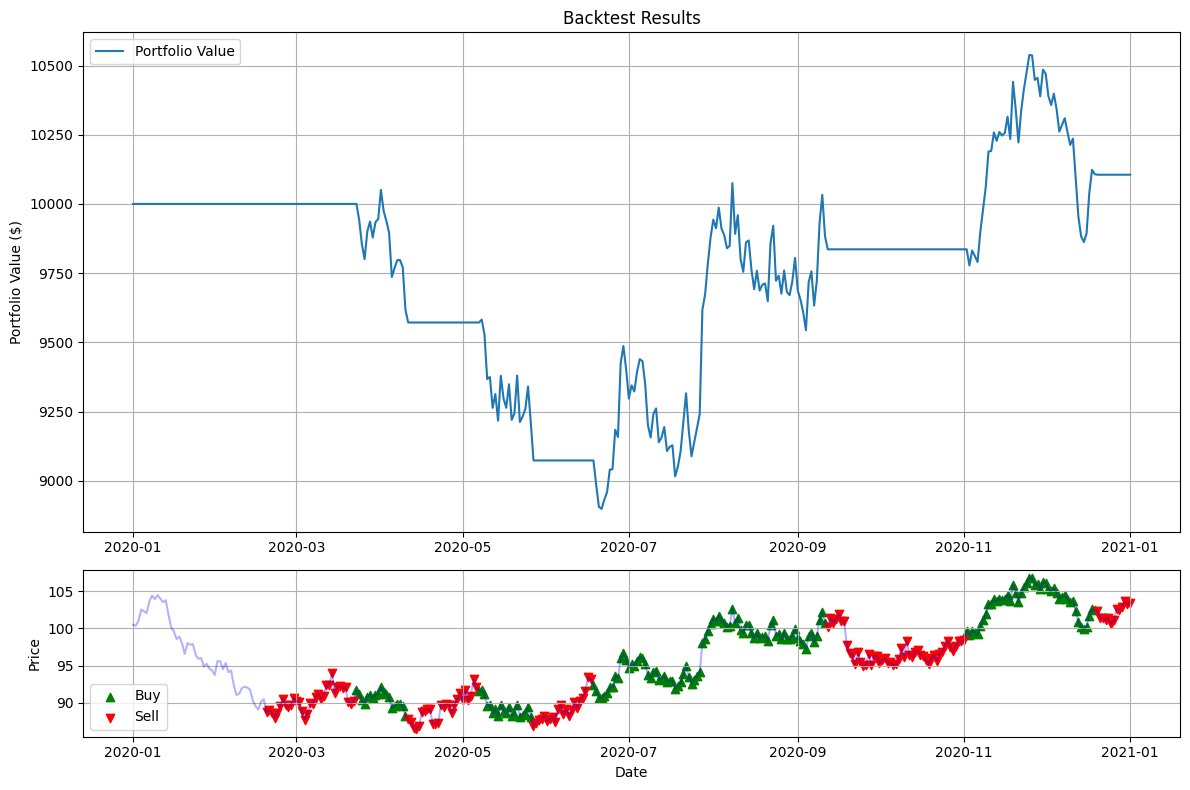


Function-based approach result:
Total Return: -100.00%


In [3]:
# Create a simple example of a backtesting framework for quant trading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Sample implementation of a backtesting framework
class BacktestFramework:
    """
    A class-based framework for backtesting trading strategies.
    """
    def __init__(self, data, initial_capital=10000.0):
        """
        Initialize the backtesting framework.
        
        Parameters:
        -----------
        data : pandas.DataFrame
            Historical price data with at least 'date' and 'close' columns
        initial_capital : float
            Starting capital for the backtest
        """
        self.data = data
        self.initial_capital = initial_capital
        self.positions = pd.DataFrame(index=data.index).fillna(0.0)
        self.portfolio_value = pd.DataFrame(index=data.index, columns=['portfolio_value']).fillna(0.0)
        self.trades = []
        
    def generate_signals(self, strategy_func):
        """
        Generate trading signals based on the provided strategy function.
        
        Parameters:
        -----------
        strategy_func : function
            A function that takes price data and returns signals (1 for buy, -1 for sell, 0 for hold)
        """
        self.signals = strategy_func(self.data)
        return self.signals
    
    def execute_backtest(self):
        """
        Execute the backtest based on the generated signals.
        """
        # Initialize portfolio and holdings
        portfolio = self.initial_capital
        holdings = 0
        
        # Track portfolio value over time
        self.portfolio_value.iloc[0] = portfolio
        
        # Iterate through data points
        for i in range(1, len(self.data)):
            # Get current price and signal
            current_price = self.data['close'].iloc[i]
            current_signal = self.signals.iloc[i]
            prev_signal = self.signals.iloc[i-1]
            
            # Check for trade
            if current_signal == 1 and prev_signal != 1:  # Buy signal
                # Calculate position size (simplified: invest all available capital)
                position_size = portfolio / current_price
                holdings += position_size
                cost = position_size * current_price
                portfolio -= cost
                
                # Record trade
                self.trades.append({
                    'date': self.data.index[i],
                    'type': 'buy',
                    'price': current_price,
                    'quantity': position_size,
                    'cost': cost
                })
                
            elif current_signal == -1 and prev_signal != -1:  # Sell signal
                # Sell all holdings
                revenue = holdings * current_price
                portfolio += revenue
                
                # Record trade
                self.trades.append({
                    'date': self.data.index[i],
                    'type': 'sell',
                    'price': current_price,
                    'quantity': holdings,
                    'revenue': revenue
                })
                
                holdings = 0
            
            # Update portfolio value
            self.portfolio_value.iloc[i] = portfolio + (holdings * current_price)
            # Update positions
            self.positions.iloc[i] = holdings
    
    def calculate_metrics(self):
        """
        Calculate performance metrics for the backtest.
        """
        # Extract portfolio values
        portfolio_values = self.portfolio_value.iloc[:, 0]
        
        # Calculate daily returns
        daily_returns = portfolio_values.pct_change().dropna()
        
        # Calculate metrics
        total_return = (portfolio_values.iloc[-1] / self.initial_capital) - 1
        
        # Annualized return (assuming 252 trading days)
        n_days = len(portfolio_values)
        annualized_return = (1 + total_return) ** (252 / n_days) - 1
        
        # Volatility (annualized)
        volatility = daily_returns.std() * np.sqrt(252)
        
        # Sharpe ratio (assuming risk-free rate of 0 for simplicity)
        sharpe_ratio = annualized_return / volatility if volatility != 0 else 0
        
        # Maximum drawdown
        cumulative_returns = (1 + daily_returns).cumprod()
        running_max = cumulative_returns.cummax()
        drawdowns = (cumulative_returns / running_max) - 1
        max_drawdown = drawdowns.min()
        
        # Win rate
        if len(self.trades) > 0:
            buy_trades = [t for t in self.trades if t['type'] == 'buy']
            sell_trades = [t for t in self.trades if t['type'] == 'sell']
            
            # Pair trades to calculate profit/loss
            profits = []
            for i in range(min(len(buy_trades), len(sell_trades))):
                buy_price = buy_trades[i]['price']
                sell_price = sell_trades[i]['price']
                profit = (sell_price - buy_price) / buy_price
                profits.append(profit)
            
            win_rate = sum(1 for p in profits if p > 0) / len(profits) if profits else 0
            
            # Profit factor
            gross_profits = sum(p for p in profits if p > 0) if profits else 0
            gross_losses = abs(sum(p for p in profits if p < 0)) if profits else 0
            profit_factor = gross_profits / gross_losses if gross_losses != 0 else float('inf')
        else:
            win_rate = 0
            profit_factor = 0
        
        return {
            'Total Return': total_return * 100,
            'Annualized Return': annualized_return * 100,
            'Volatility': volatility * 100,
            'Sharpe Ratio': sharpe_ratio,
            'Max Drawdown': max_drawdown * 100,
            'Win Rate': win_rate * 100,
            'Profit Factor': profit_factor,
            'Number of Trades': len(self.trades) // 2  # Divide by 2 since each round trip is 2 trades
        }
    
    def plot_results(self):
        """
        Plot the backtest results.
        """
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1]})
        
        # Plot portfolio value
        ax1.plot(self.portfolio_value.index, self.portfolio_value.values, label='Portfolio Value')
        ax1.set_title('Backtest Results')
        ax1.set_ylabel('Portfolio Value ($)')
        ax1.legend()
        ax1.grid(True)
        
        # Plot buy/sell signals
        buy_signals = self.signals == 1
        sell_signals = self.signals == -1
        
        ax2.plot(self.data.index, self.data['close'], color='blue', alpha=0.3)
        ax2.scatter(self.data.index[buy_signals], self.data.loc[buy_signals, 'close'], 
                   color='green', marker='^', label='Buy')
        ax2.scatter(self.data.index[sell_signals], self.data.loc[sell_signals, 'close'], 
                   color='red', marker='v', label='Sell')
        ax2.set_ylabel('Price')
        ax2.set_xlabel('Date')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()


# Example usage with a simple moving average crossover strategy
def moving_average_crossover(data, short_window=20, long_window=50):
    """
    A simple moving average crossover strategy.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        Historical price data with at least 'close' column
    short_window : int
        Short moving average window
    long_window : int
        Long moving average window
    
    Returns:
    --------
    pandas.Series
        Series of signals (1 for buy, -1 for sell, 0 for hold)
    """
    signals = pd.Series(index=data.index, data=0)
    
    # Create moving averages
    data['short_ma'] = data['close'].rolling(window=short_window).mean()
    data['long_ma'] = data['close'].rolling(window=long_window).mean()
    
    # Generate signals
    signals[data['short_ma'] > data['long_ma']] = 1  # Buy signal
    signals[data['short_ma'] < data['long_ma']] = -1  # Sell signal
    
    return signals

# Create sample data
dates = pd.date_range(start='2020-01-01', end='2021-01-01', freq='D')
np.random.seed(42)  # For reproducibility
prices = 100 + np.cumsum(np.random.normal(0, 1, len(dates)))
sample_data = pd.DataFrame({
    'close': prices,
    'open': prices * 0.99,
    'high': prices * 1.01,
    'low': prices * 0.98,
    'volume': np.random.randint(1000, 10000, len(dates))
}, index=dates)

# Create and run backtest
backtest = BacktestFramework(sample_data)
backtest.generate_signals(moving_average_crossover)
backtest.execute_backtest()
metrics = backtest.calculate_metrics()

# Print metrics
print("Performance Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")

# Plot results
backtest.plot_results()

# ================================================================================================

# Example of a function-based approach for comparison
def backtest_strategy(data, strategy_func, initial_capital=10000.0):
    """
    A function-based approach to backtesting.
    
    Parameters:
    -----------
    data : pandas.DataFrame
        Historical price data
    strategy_func : function
        Trading strategy function that returns signals
    initial_capital : float
        Initial capital for the backtest
    
    Returns:
    --------
    dict
        Performance metrics
    """
    # Generate signals
    signals = strategy_func(data)
    
    # Initialize portfolio tracking
    portfolio = pd.Series(index=data.index, data=initial_capital)
    positions = pd.Series(index=data.index, data=0.0)
    
    # Execute backtest
    for i in range(1, len(data)):
        if signals.iloc[i] == 1 and signals.iloc[i-1] != 1:
            # Buy
            positions.iloc[i] = portfolio.iloc[i-1] / data['close'].iloc[i]
            portfolio.iloc[i] = 0
        elif signals.iloc[i] == -1 and signals.iloc[i-1] != -1:
            # Sell
            portfolio.iloc[i] = positions.iloc[i-1] * data['close'].iloc[i]
            positions.iloc[i] = 0
        else:
            # Hold
            positions.iloc[i] = positions.iloc[i-1]
            portfolio.iloc[i] = portfolio.iloc[i-1]
    
    # Calculate final portfolio value
    final_portfolio = portfolio + positions * data['close']
    
    # Calculate metrics (simplified)
    total_return = (final_portfolio.iloc[-1] / initial_capital) - 1
    
    return {
        'Total Return': total_return * 100
    }

# Compare with function-based approach
func_result = backtest_strategy(sample_data, moving_average_crossover)
print("\nFunction-based approach result:")
print(f"Total Return: {func_result['Total Return']:.2f}%")
